In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Activation,Conv2D,MaxPooling2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
from matplotlib import pyplot as plt
import shutil
import cv2
from PIL import Image
import tensorflow as tf 
from tqdm import tqdm_notebook
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.layers import Dense,concatenate,Activation,BatchNormalization

In [2]:
os.chdir('./../input/')
os.listdir()

['train.csv',
 'sample_submission.csv',
 'test.csv',
 'train_images',
 'test_images']

In [3]:
train_csv = pd.read_csv('./train.csv')
test_csv = pd.read_csv('./test.csv')
sub = pd.read_csv('./sample_submission.csv')

In [4]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
train_csv['id_code'] = train_csv['id_code'].map(lambda x: x+'.png')
test_csv['id_code'] = test_csv['id_code'].map(lambda x: x+'.png')

In [6]:
train_csv['diagnosis'] = train_csv['diagnosis'].apply(str)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(train_csv.id_code,train_csv.diagnosis,test_size=0.2)

In [8]:
generator = ImageDataGenerator(rescale=1.0/255.0,
                              vertical_flip=True,
                              horizontal_flip=True,
                              zoom_range=0.2,
                              validation_split=0.2)

In [9]:
path = './train_images'
train_generator = generator.flow_from_dataframe(dataframe = train_csv,
                                               x_col = 'id_code',
                                               y_col = 'diagnosis',
                                               directory = path,
                                               class_mode = 'categorical',
                                               target_size = (224,224),
                                               batch_size = 128,
                                               shuffle = False,
                                               subset = 'training')

Found 2930 validated image filenames belonging to 5 classes.


In [10]:
validation_generator = generator.flow_from_dataframe(dataframe = train_csv,
                                               x_col = 'id_code',
                                               y_col = 'diagnosis',
                                               directory = path,
                                               class_mode = 'categorical',
                                               target_size = (224, 224),
                                               batch_size = 128,
                                               shuffle = False,
                                               subset = 'validation')

Found 732 validated image filenames belonging to 5 classes.


In [11]:
test_generator = generator.flow_from_dataframe(dataframe=test_csv,
                                              x_col='id_code',
                                              y_col=None,
                                              directory='./test_images',
                                              class_mode=None,
                                              batch_size=128)

Found 1928 validated image filenames.


In [12]:
os.chdir('./train_images')
train_img_label = os.listdir()
os.chdir('./../')

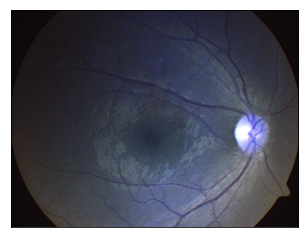

In [13]:
label = 'cd01672507c9.png'
path = f'./train_images/{label}'
image = cv2.imread(path)
img_shape = image.shape
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
#plt.imshow(gray)

In [ ]:
img_shape

In [ ]:
for label in train_img_label:
    path = f'./train_image/{label}'
    image = cv2.imread(path)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image)
    plt.imshow(gray)
    break

In [15]:
def inception_network_v1(input_shape, num_classes):

	"""Arguments:
		input_shape : The number of rows,number of columns,number of color channels in the image
    The ordering of the dimensions in the inputs,"Channel Last"
		Example : (512,512,3) => This represents 512x512 pixel image with 3 color channels
		num_classes : The number of classes we want to predict
	   Output:
	   	Return the Inception model with the given constraints
	"""

	input_ = Input(shape = input_shape)

	#==============================================================================================================================
	#Strating of First BLock
	tower1_1 = Conv2D(filters = 64, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_)

	tower2_1 = Conv2D(filters = 64, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_)
	tower2_2 = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(tower2_1)

	tower3_1 = Conv2D(filters = 64, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_)
	tower3_2 = Conv2D(filters = 64, kernel_size = (5,5), padding = 'same', activation = 'relu')(tower3_1)

	tower4_1 = MaxPooling2D(pool_size = (3,3), strides = (1,1), padding = 'same')(input_)
	tower4_2 = Conv2D(filters = 64, kernel_size = (1,1), padding = 'same', activation = 'relu')(tower4_1)

	concat_1 = concatenate([tower1_1,tower2_1,tower3_1,tower4_1], axis = 3)
	#First BLock Finished

	#===============================================================================================================================
	#Same for Every end of the block with flatten function refering to the last concatenation layer
	end_block = Conv2D(filters = 8, kernel_size = (3,3))(concat_1)
	end_block = Activation('relu')(end_block)
	end_block = MaxPooling2D(pool_size = (2,2), strides = (1,1))(end_block)
	end_block = Flatten()(end_block)
	end_block = Dense(num_classes)(end_block)
	
	output = Activation('softmax')(end_block)

	model = Model([input_], output)

	return model

In [16]:
model = inception_network_v1((224,224,3),5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 224, 224, 64) 256         input_1[0][0]                    
______________________________________________________________________________________________

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='mean_squared_error',metrics=['acc'])

In [ ]:
history = model.fit_generator(generator=train_generator,
                            steps_per_epoch=50,
                            validation_data=validation_generator,
                            validation_steps=60,
                            epochs=15,
                            verbose=1)